# Springboard--DSC Program

# Capstone Project 1 - Regression with SMOTE and Under-Sampling
### by Ellen A. Savoye

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# Import packages and data


In [2]:
# !pip install wordcloud
# !pip install kaggle
# !pip install spacy
# !pip install swifter
# !pip install tqdm
!pip install -U git+https://github.com/scikit-learn-contrib/imbalanced-learn.git

  Cloning https://github.com/scikit-learn-contrib/imbalanced-learn.git to /tmp/pip-req-build-on0027x_
  Running command git clone -q https://github.com/scikit-learn-contrib/imbalanced-learn.git /tmp/pip-req-build-on0027x_
     |████████████████████████████████| 6.9MB 2.7MB/s 
  Created wheel for imbalanced-learn: filename=imbalanced_learn-0.7.0-cp36-none-any.whl size=167059 sha256=cdd355011e9ac4c5183ae28974c2ab8577a5560b334edb4530ee2091472e698d
  Stored in directory: /tmp/pip-ephem-wheel-cache-llg6v7vm/wheels/6c/07/cf/38cb9b7cc9e6a0ac7648a80ec192b6f2d863405fb0049ac0ff
Successfully built imbalanced-learn
  Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1
  Found existing installation: imbalanced-learn 0.4.3
    Uninstalling imbalanced-learn-0.4.3:
      Successfully uninstalled imbalanced-learn-0.4.3


In [15]:
import pandas as pd
import numpy as np
import itertools
from collections import Counter

# libraries for NLP
import spacy
import nltk
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
import sklearn.model_selection
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, roc_curve, roc_auc_score
# ref: http://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html#sklearn.metrics.classification_report
from six.moves import range
import scipy.sparse

# for imbalanced datasets
import imblearn
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

# libraries for getting and moving data
import os
from os import path
import shutil
from zipfile import ZipFile

# for Images
from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
%matplotlib inline

In [4]:
# set seed
np.random.seed(42)

In [5]:
# Set directories
# Google Colab
src = "/content/drive/My Drive/DS-Capstone_1/Code/"
dst = "/content/drive/My Drive/DS-Capstone_1/Data/"

# Local computer
# src = "C:\\Users\\ellen\\Documents\\GitHub\\Data_Science_Career_Track\\Capstone_1\\Code\\"
# dst = "C:\\Users\\ellen\\Documents\\GitHub\\Data_Science_Career_Track\\Capstone_1\\Data\\"

# Work computer
# src = "C:\\Users\\esavoye\\Documents\\GitHub\\Data_Science_Career_Track\\Capstone_1\\Code\\"
# dst = "C:\\Users\\esavoye\\Documents\\GitHub\\Data_Science_Career_Track\\Capstone_1\\Data\\"

# Computer path
# unpickled_df = pd.read_pickle(dst + '/full_data_w_features.pkl')
# unpickled_df_slimmed = pd.read_pickle(dst + '/slimmed_data_w_features.pkl')

# Colab path
unpickled_df = pd.read_pickle(dst + 'full_data_w_features.pkl')
unpickled_df_slimmed = pd.read_pickle(dst + 'slimmed_data_w_features.pkl')


# Test Set & Countvectorizer


Both logistic regression and naive bayes take an X and y input. After applying countvectorizer, the data is split into train and test sets. I'm using stratify to keep the split given that only 8% of the data is labelled as toxic. Without using stratify, the imbalance in my data has the potential to be even worse. 

In [6]:
# grab text field
cleaned_text = unpickled_df.clean_text

In [7]:
# create an object of class - Count_Vectorizer
vectorizer = CountVectorizer()

In [8]:
# call `fit_transform` to build the vocabulary and to convert text to a bag of words
x = vectorizer.fit_transform(cleaned_text)
type(x)

scipy.sparse.csr.csr_matrix

In [9]:
# Inputs:
#         critics: a Pandas dataframe that contains the dataset.
#         In particular, this dataframe is expected to have a column 
#         called 'quote', and critics.quote is a Series containing
#         all documents, which is this case are movie reviews.
#
#         vectorizer: is expected to be an object of a class from
#         sklearn.feature_extraction.text, (*)
#         or None, in which case, per the code below, is constructed
#         according to class CountVectorizer.
#
# Outputs:
#         X: document-term matrix associated with critics.quote,
#         according to the vectorization implemented by object 
#         vectorizer.
#
#         y: this is the label vector, such that y[i] is the label
#         associated with document i, encoded according to row i of X
#
#         vectorizer: vectorizer_object object built
#**************************************************************************
def make_xy(unpickled_df, vectorizer=None):
    if vectorizer is None:
        vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(unpickled_df.clean_text)
    X = X.tocsc()
    y = (unpickled_df.target_binary == 1).values.astype(np.int)
    return X, y, vectorizer

X, y, vectorizer = make_xy(unpickled_df)

In [10]:
# # Create file for use in the future 
# scipy.sparse.save_npz(dst + '/X.pkl', X)
# np.save(dst + '/y.npy', y)

In [11]:
# load files for use in the future 
X = scipy.sparse.load_npz(dst + 'X.pkl.npz')
y = np.load(dst + 'y.npy')

In [12]:
counter = Counter(y)
print(counter)

Counter({0: 1660540, 1: 144334})


# SMOTE with Random Undersampling of the Majority Class

Previously, I ran a logistic regression and Naive Bayes model for my baseline. Following that, I ran both logistic regression and Naive Bayes using over-sampling (SMOTE) where both toxic and non-toxic values have the same count. During this run, I will be including an random undersampling of the majority class (non-toxic) after applying SMOTE.

In [13]:
# load files for use in the future 
# X_resample = scipy.sparse.load_npz(dst + 'X_resample.pkl.npz')
# y_resample = np.load(dst + 'y_resample.npy')

In [16]:
# oversample = SMOTE() with undersampling
over = SMOTE(sampling_strategy=0.2)
under = RandomUnderSampler(sampling_strategy=0.5)
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)
# transform the dataset
X_resample, y_resample = pipeline.fit_resample(X, y)


In [17]:
# summarize the new class distribution
counter = Counter(y_resample)
print(counter)

Counter({0: 664216, 1: 332108})


In [18]:
# create x and y split for train and test sets 

Xtrain, Xtest, ytrain, ytest = train_test_split(X_resample, y_resample, stratify=y_resample)

In [19]:
# # Create file for use in the future 
# scipy.sparse.save_npz(dst + '/X_resample.pkl', X_resample)
# np.save(dst + '/y_resample.npy', y_resample)

# Logistic Regression - Post SMOTE

In [20]:
# Construct the LogisticRegression model
clf = LogisticRegression()

# Fit the model on the trainng data.
clf.fit(Xtrain, ytrain)

# Print the accuracy from the testing data.
y_predict_test = clf.predict(Xtest)
print("\n")
print("[Test] Accuracy score (y_predict_test, ytest):",accuracy_score(y_predict_test, ytest))

print("\n")
print("[Test] Accuracy score: (ytest, y_predict_test)",accuracy_score(ytest, y_predict_test))

y_predict_training = clf.predict(Xtrain)
print("\n")
print("[Training] Accuracy score: (ytrain, y_predict_training)",accuracy_score(ytrain, y_predict_training))

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)




[Test] Accuracy score (y_predict_test, ytest): 0.8755224204174545


[Test] Accuracy score: (ytest, y_predict_test) 0.8755224204174545


[Training] Accuracy score: (ytrain, y_predict_training) 0.8811337142000661


In [21]:
# more comprehensive performance analysis

target_names = ['Non-Toxic', 'Toxic']

print("[Training Classification Report]")
print(classification_report(ytrain, y_predict_training, target_names=target_names))

print("[Test Classification Report]")
print(classification_report(ytest, y_predict_test, target_names=target_names))

[Training Classification Report]
              precision    recall  f1-score   support

   Non-Toxic       0.88      0.95      0.91    498162
       Toxic       0.88      0.75      0.81    249081

    accuracy                           0.88    747243
   macro avg       0.88      0.85      0.86    747243
weighted avg       0.88      0.88      0.88    747243

[Test Classification Report]
              precision    recall  f1-score   support

   Non-Toxic       0.88      0.94      0.91    166054
       Toxic       0.87      0.74      0.80     83027

    accuracy                           0.88    249081
   macro avg       0.87      0.84      0.85    249081
weighted avg       0.88      0.88      0.87    249081



During the baseline run, the train dataset for non-toxic classification fared very well with precision and recall at 96% and 99% respectively. Train dataset for toxic classification fared poorly with precision and recall at 76% and 49% respectively. The test set had similar numbers.

When applying SMOTE, the toxic classification, for both train and test, drastically increase to 91% and 95% for precision and recall respectively. Average precision and average recall is 93%.

For SMOTE with under-sampling, we can see our results are worse for both non-toxic and toxic with similar results for train and test.

# Naive Bayes

In [22]:
# multinomial naive bayes classifier
nBayes = MultinomialNB()

# same X and y used for logistic regression
clf_nBayes = nBayes.fit(Xtrain, ytrain)

accuracy_train = nBayes.score(Xtrain,ytrain)
accuracy_test = nBayes.score(Xtest,ytest)

print('The training accuracy is %f and the test accuracy is %f' %(accuracy_train, accuracy_test))

The training accuracy is 0.836772 and the test accuracy is 0.816827


The gap between training and test accuracy does not imply overfitting.

In [23]:

# Print the accuracy from the testing data.
y_predict_test = clf_nBayes.predict(Xtest)
print("\n")
print("[Test] Accuracy score (y_predict_test, ytest):",accuracy_score(y_predict_test, ytest))

print("\n")
print("[Test] Accuracy score: (ytest, y_predict_test)",accuracy_score(ytest, y_predict_test))

y_predict_training = clf_nBayes.predict(Xtrain)
print("\n")
print("[Training] Accuracy score: (ytrain, y_predict_training)",accuracy_score(ytrain, y_predict_training))




[Test] Accuracy score (y_predict_test, ytest): 0.8168266547829822


[Test] Accuracy score: (ytest, y_predict_test) 0.8168266547829822


[Training] Accuracy score: (ytrain, y_predict_training) 0.8367719737755991


In [24]:
# more comprehensive performance analysis for NB

target_names = ['Non-Toxic', 'Toxic']

print("[Training Classification Report]")
print(classification_report(ytrain, y_predict_training, target_names=target_names))

print("[Test Classification Report]")
print(classification_report(ytest, y_predict_test, target_names=target_names))

[Training Classification Report]
              precision    recall  f1-score   support

   Non-Toxic       0.86      0.91      0.88    498162
       Toxic       0.79      0.70      0.74    249081

    accuracy                           0.84    747243
   macro avg       0.82      0.80      0.81    747243
weighted avg       0.83      0.84      0.83    747243

[Test Classification Report]
              precision    recall  f1-score   support

   Non-Toxic       0.85      0.89      0.87    166054
       Toxic       0.75      0.68      0.71     83027

    accuracy                           0.82    249081
   macro avg       0.80      0.78      0.79    249081
weighted avg       0.81      0.82      0.81    249081



In a similar manner to the logistic regression results, the non-toxic and toxic classification for both the train and test set is better than baseline but worse than SMOTE. 

In [25]:
# calculate roc curve
fpr, tpr, thresholds = roc_curve(ytrain, y_predict_training)

In [26]:
# calculate AUC
auc = roc_auc_score(ytrain, y_predict_training)
print('AUC: %.3f' % auc)

AUC: 0.802


No handles with labels found to put in legend.


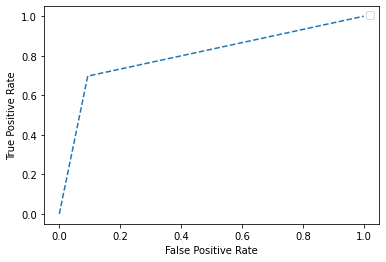

In [27]:
# plot the roc curve for the model
plt.plot(fpr, tpr, linestyle='--')

# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

A good measure of separability implying an excellent model is an AUC near 1. When AUC is 0.5, it means model has no class separation capacity whatsoever. Given an AUC of 0.80, it means there is 80% chance that model will be able to distinguish between positive class (toxic) and negative class (non-toxic). The baseline and SMOTE AUC was 0.81.
